In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import scipy.stats as sps
from sympy import *
from matplotlib import cm
plt.style.use('ggplot')
%matplotlib inline

def scan_from_csv(filename,header=None):
    if not header:
        return pd.read_csv(filename,na_values='None')
    else:
        return pd.read_csv(filename,na_values='None',header=-1)

def write_answer_to_file(answer,file):
    with open(file, 'w') as answer_file:  
        answer_file.write(answer)

In [2]:
data = pd.read_csv('hw6t3v0.txt',delimiter='\\s+',header=-1)

In [3]:
data.head()

,0,1
0,783.1,1115.0
1,891.2,1200.9
2,825.8,1195.1
3,706.3,984.1
4,880.3,1206.0


In [4]:
data.shape

(200, 2)

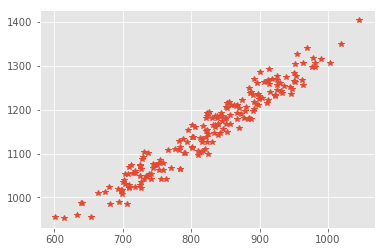

In [5]:
plt.plot(data[0],data[1],'*')

Как видно, корреляция между выборками есть.

Пусть наши данные это две выборки $X = (x_i),Y=(y_j)$. Тогда парность этих выборок равносильна тому что векторный набор $Z= \binom {x_i}{y_i}$ является выборкой.

Но проверять вектора на то что это выборки мы не умеем, поэтому рассмотрим наборы $(x_i * y_i) , (x_i + y_i)$. Они должны являться выборками если $Z$ выборка. Вот для них и применим критерии проверки наборов на выборки(критерий Вальда-Волфовица).

Воспользуемся сложной проверкой гипотез и проверим выборки парность, на некоррелированность(критериями Спирмена, Пирсона и Кэндела), на независимость(таблицами сопряжнности), на нормальность(Шапиро-Уилка, $\chi^2$, KS-test) низходящим методом Холма при $FWER \leq 0.1$.

In [112]:
from statsmodels.sandbox.stats.multicomp import multipletests  # Holm method
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.stats import kendalltau
from skgof import ks_test  # KS for Lillieforce test
from scipy.stats import chisquare  # chi^2 test
from skidmarks import wald_wolfowitz # Wald-Wollfowitz test
from scipy.stats import shapiro  # Shapiro-Wilk test
from scipy.stats import chi2_contingency  # Contigency Table statistic

In [141]:
def make_contigency_table(X,Y,method='auto'):
    junk, binx = np.histogram(X,bins=method)
    junk, biny = np.histogram(Y,bins=method)
    
    table = np.zeros((len(binx)-1,len(biny)-1))
    for i in range(len(binx)-1):
        for j in range(len(biny)-1):
            table[i][j] = np.sum([(x > binx[i] and x <= binx[i+1] 
                                   and y > biny[j] and y <= biny[j+1]) 
                                  for x,y in zip(X,Y)])
    for i in range(len(binx)-1):
        for j in range(len(biny)-1):
            if table[i][j] == 0:
                table[i][j] = 1
    return table

def run_inversions_p_value(x):
    #  simple O(N^2) realisation
    inv = 0
    n = len(x)
    for i in range(n):
        for j in range(i+1,n):
            inv += (x[i] > x[j])
    mean = n*(n-1)/4
    sigma2 = (2*n**3 + 3*n**2 - 5*n)/72
    xi = (inv - mean)/(sigma2**0.5)
    p0 = sps.norm.cdf(xi)
    p1 = 1 - p0
    return 2*min(p0,p1)   # asymptotic two-tailed p_value

def run_chisquare_norm(x):
    f_obs, bins = np.histogram(x,bins='auto')
    m = np.mean(x)
    s = np.std(x)
    f_exp = np.array([sps.norm.cdf(x=bins[i+1],loc=m,scale=s) - 
                      sps.norm.cdf(x=bins[i],loc=m,scale=s)
                      for i in range(len(bins)-1)]) * np.sum(f_obs)

    return chisquare(f_obs=f_obs, f_exp=f_exp)[1]

In [114]:
# adaptive criteries
run_criteries = [
    (lambda x, y: chi2_contingency(make_contigency_table(x,y))[1]),
    (lambda x, y: spearmanr(x,y)[1]),
    (lambda x, y: pearsonr(x,y)[1]),
    (lambda x, y: kendalltau(x,y)[1]),
    run_chisquare_norm,
    (lambda x: ks_test(x,sps.norm(loc=np.mean(x),scale=np.std(x)))[1]),
    (lambda x: shapiro(x)[1]),
    (lambda x: wald_wolfowitz(x > np.median(x))['p']),
    run_inversions_p_value
]

alphas = [0.1]
for a in alphas:
    p_values = []
    for ex in run_criteries[:4]:
        p_values.append(ex(data[0], data[1]))
    for ex in run_criteries[4:7]:
        p_values.append(ex(data[0]))
        p_values.append(ex(data[1]))
    summ = np.array(data[0]) + np.array(data[1])
    mult = np.array(data[0]) * np.array(data[1])
    for ex in run_criteries[7:]:
        p_values.append(ex(summ))
        p_values.append(ex(mult))
    reject = multipletests(pvals=p_values, method='holm',alpha=a)[0]
    print('for alpha = ' + str(a) + ' : ' + str(np.sum(reject)) + ' simple hypotheses are rejected:')
    print('p_values: ' + str(p_values))
    print('reject_bits: ' + str(reject))
    print()

for alpha = 0.1 : 4 simple hypotheses are rejected:
p_values: [5.8159584736017975e-39, 6.9452667366409923e-122, 1.6281730406992918e-122, 1.6548060638644097e-70, 0.056617272558496468, 0.25162157071166374, 0.41554047781226422, 0.29940525942699536, 0.06311605125665665, 0.024712642654776573, 0.6647034282680907, 0.6647034282680907, 0.57111413901992014, 0.57976325808093576]
reject_bits: [ True  True  True  True False False False False False False False False
 False False]



Таким образом на уровне значимости 0.1 отвергаем независимость и некоррелированность, 
не отвергаем парность и нормальность.

Коэффиценты различных выборочных корреляций говорят, что выборки сильно коррелированы:

In [18]:
print(pearsonr(data[0],data[1])[0])
print(spearmanr(data[0],data[1])[0])
print(kendalltau(data[0],data[1])[0])

0.969240726781
0.968779543874
0.84448913147


В таком случае по условию требуется в дополнение к предыдущим гипотезам проверить гипотезу об однородности, то есть о совпадении параметров распределений. Тогда добавим к списку простых гипотез t-критерий стьюдента для связанных выборок.

In [140]:
# adaptive criteries
run_criteries = [
    (lambda x, y: chi2_contingency(make_contigency_table(x,y))[1]),
    (lambda x, y: spearmanr(x,y)[1]),
    (lambda x, y: pearsonr(x,y)[1]),
    (lambda x, y: kendalltau(x,y)[1]),
    run_chisquare_norm,
    (lambda x: ks_test(x,sps.norm(loc=np.mean(x),scale=np.std(x)))[1]),
    (lambda x: shapiro(x)[1]),
    (lambda x: wald_wolfowitz(x > np.median(x))['p']),
    run_inversions_p_value,
    (lambda x, y: sps.ttest_rel(x,y)[1]),
]

alphas = [0.1]
for a in alphas:
    p_values = []
    for ex in run_criteries[:4]:
        p_values.append(ex(data[0], data[1]))
    for ex in run_criteries[4:7]:
        p_values.append(ex(data[0]))
        p_values.append(ex(data[1]))
    summ = np.array(data[0]) + np.array(data[1])
    mult = np.array(data[0]) * np.array(data[1])
    for ex in run_criteries[7:9]:
        p_values.append(ex(summ))
        p_values.append(ex(mult))
    for ex in run_criteries[9:]:
        p_values.append(ex(data[0], data[1]))
    reject = multipletests(pvals=p_values, method='holm',alpha=a)[0]
    print('for alpha = ' + str(a) + ' : ' + str(np.sum(reject)) + ' simple hypotheses are rejected:')
    print('p_values: ' + str(p_values))
    print('reject_bits: ' + str(reject))
    print()

for alpha = 0.1 : 5 simple hypotheses are rejected:
p_values: [5.8159584736017975e-39, 6.9452667366409923e-122, 1.6281730406992918e-122, 1.6548060638644097e-70, 0.056617272558496468, 0.25162157071166374, 0.41554047781226422, 0.29940525942699536, 0.06311605125665665, 0.024712642654776573, 0.6647034282680907, 0.6647034282680907, 0.57111413901992014, 0.57976325808093576, 2.4606555924480782e-231]
reject_bits: [ True  True  True  True False False False False False False False False
 False False  True]



Как видно, гипотеза об однородности распределений отвергается